# 18. Holiday & Event Calendar Features

**Story 1.8**: Build Holiday & Event Calendar

## Objectives
- Create features for holidays, school breaks, major events
- Generate binary indicators for special days affecting traffic
- Add weekend/weekday features
- Merge calendar features with main dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries loaded successfully')

Libraries loaded successfully


## 1. Load Holiday Data

In [2]:
# Try to load existing holiday data
try:
    holidays_df = pd.read_csv('../data/external/holidays/holidays_combined_2020_2025.csv')
    holidays_df['date'] = pd.to_datetime(holidays_df['date'] if 'date' in holidays_df.columns else holidays_df.iloc[:, 0])
    print(f'Loaded {len(holidays_df)} holiday records')
except:
    # Create synthetic holiday data for Slovenia
    print('Creating synthetic holiday data for Slovenia...')
    
    # Define Slovenian holidays (2020-2024)
    holidays_data = []
    
    for year in range(2020, 2025):
        # Fixed date holidays
        holidays_data.extend([
            {'date': f'{year}-01-01', 'name': "New Year's Day", 'type': 'public'},
            {'date': f'{year}-01-02', 'name': "New Year's Day (2nd)", 'type': 'public'},
            {'date': f'{year}-02-08', 'name': 'Prešeren Day', 'type': 'public'},
            {'date': f'{year}-04-27', 'name': 'Day of Uprising Against Occupation', 'type': 'public'},
            {'date': f'{year}-05-01', 'name': 'Labour Day', 'type': 'public'},
            {'date': f'{year}-05-02', 'name': 'Labour Day (2nd)', 'type': 'public'},
            {'date': f'{year}-06-25', 'name': 'Statehood Day', 'type': 'public'},
            {'date': f'{year}-08-15', 'name': 'Assumption of Mary', 'type': 'public'},
            {'date': f'{year}-10-31', 'name': 'Reformation Day', 'type': 'public'},
            {'date': f'{year}-11-01', 'name': 'All Saints Day', 'type': 'public'},
            {'date': f'{year}-12-25', 'name': 'Christmas', 'type': 'public'},
            {'date': f'{year}-12-26', 'name': 'Independence and Unity Day', 'type': 'public'},
        ])
        
        # Easter-related holidays (simplified - would need proper calculation)
        easter_dates = {
            2020: '2020-04-12', 2021: '2021-04-04', 2022: '2022-04-17',
            2023: '2023-04-09', 2024: '2024-03-31'
        }
        if year in easter_dates:
            easter = pd.to_datetime(easter_dates[year])
            holidays_data.append({'date': easter, 'name': 'Easter Sunday', 'type': 'public'})
            holidays_data.append({'date': easter + timedelta(days=1), 'name': 'Easter Monday', 'type': 'public'})
    
    holidays_df = pd.DataFrame(holidays_data)
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    print(f'Created {len(holidays_df)} holiday records')

# Display sample holidays
print('\nSample holidays:')
print(holidays_df.head(10))

Loaded 1956 holiday records

Sample holidays:
        date country            holiday_name    type            region  \
0 2020-01-01      AT          New Year's Day  public               NaN   
1 2020-01-01      DE          New Year's Day  public               NaN   
2 2020-01-01      IT          New Year's Day  public               NaN   
3 2020-01-01      SI          New Year's Day  public               NaN   
4 2020-01-02      SI        New Year Holiday  public               NaN   
5 2020-01-06      AT                Epiphany  public               NaN   
6 2020-01-06      DE                Epiphany  public           Bavaria   
7 2020-01-06      IT                Epiphany  public               NaN   
8 2020-02-08      SI            Prešeren Day  public               NaN   
9 2020-02-15      SI  Winter Holiday Group 1  school  Eastern Slovenia   

  day_of_week  year  month  
0   Wednesday  2020      1  
1   Wednesday  2020      1  
2   Wednesday  2020      1  
3   Wednesday  2020    

## 2. Define School Break Periods

In [3]:
# Define school break periods for Slovenia
school_breaks = []

for year in range(2020, 2025):
    # Winter break (around New Year)
    school_breaks.append({
        'start': f'{year-1}-12-24',
        'end': f'{year}-01-02',
        'name': 'Winter Break',
        'year': year
    })
    
    # February break (1 week)
    school_breaks.append({
        'start': f'{year}-02-15',
        'end': f'{year}-02-22',
        'name': 'February Break',
        'year': year
    })
    
    # Spring break (around May 1st)
    school_breaks.append({
        'start': f'{year}-04-27',
        'end': f'{year}-05-02',
        'name': 'Spring Break',
        'year': year
    })
    
    # Summer break (July-August)
    school_breaks.append({
        'start': f'{year}-06-25',
        'end': f'{year}-08-31',
        'name': 'Summer Break',
        'year': year
    })
    
    # Autumn break (around November 1st)
    school_breaks.append({
        'start': f'{year}-10-28',
        'end': f'{year}-11-01',
        'name': 'Autumn Break',
        'year': year
    })

school_breaks_df = pd.DataFrame(school_breaks)
school_breaks_df['start'] = pd.to_datetime(school_breaks_df['start'])
school_breaks_df['end'] = pd.to_datetime(school_breaks_df['end'])

print(f'Defined {len(school_breaks_df)} school break periods')
print('\nSchool breaks for 2024:')
print(school_breaks_df[school_breaks_df['year'] == 2024][['name', 'start', 'end']])

Defined 25 school break periods

School breaks for 2024:
              name      start        end
20    Winter Break 2023-12-24 2024-01-02
21  February Break 2024-02-15 2024-02-22
22    Spring Break 2024-04-27 2024-05-02
23    Summer Break 2024-06-25 2024-08-31
24    Autumn Break 2024-10-28 2024-11-01


## 3. Create Calendar Feature Generator

In [4]:
def generate_calendar_features(date_range):
    """
    Generate comprehensive calendar features for a date range
    
    Parameters:
    -----------
    date_range : pd.DatetimeIndex or list of dates
    
    Returns:
    --------
    pd.DataFrame with calendar features
    """
    df = pd.DataFrame({'date': pd.to_datetime(date_range)})
    
    # Basic temporal features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    
    # Weekend indicator
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_weekday'] = (df['dayofweek'] < 5).astype(int)
    
    # Day name
    df['day_name'] = df['date'].dt.day_name()
    
    # Month name
    df['month_name'] = df['date'].dt.month_name()
    
    # Holiday features
    df['is_holiday'] = df['date'].isin(holidays_df['date']).astype(int)
    
    # Day before/after holiday
    holiday_dates = set(holidays_df['date'])
    df['day_before_holiday'] = df['date'].apply(
        lambda x: 1 if (x + timedelta(days=1)) in holiday_dates else 0
    )
    df['day_after_holiday'] = df['date'].apply(
        lambda x: 1 if (x - timedelta(days=1)) in holiday_dates else 0
    )
    
    # School break indicator
    df['is_school_break'] = 0
    for _, break_period in school_breaks_df.iterrows():
        mask = (df['date'] >= break_period['start']) & (df['date'] <= break_period['end'])
        df.loc[mask, 'is_school_break'] = 1
    
    # Season
    df['season'] = df['month'].apply(lambda x: 
        'winter' if x in [12, 1, 2] else
        'spring' if x in [3, 4, 5] else
        'summer' if x in [6, 7, 8] else
        'autumn'
    )
    
    # Tourist season (summer months)
    df['is_tourist_season'] = df['month'].isin([6, 7, 8]).astype(int)
    
    # Long weekend (Friday or Monday adjacent to holiday)
    df['is_long_weekend'] = (
        ((df['dayofweek'] == 4) & df['day_after_holiday']) |  # Friday before holiday
        ((df['dayofweek'] == 0) & df['day_before_holiday'])   # Monday after holiday
    ).astype(int)
    
    return df

# Generate features for sample dates
sample_dates = pd.date_range('2024-01-01', '2024-12-31', freq='D')
calendar_features = generate_calendar_features(sample_dates)

print('Calendar features generated!')
print(f'Shape: {calendar_features.shape}')
print('\nFeatures created:')
print(calendar_features.columns.tolist())

Calendar features generated!
Shape: (366, 19)

Features created:
['date', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend', 'is_weekday', 'day_name', 'month_name', 'is_holiday', 'day_before_holiday', 'day_after_holiday', 'is_school_break', 'season', 'is_tourist_season', 'is_long_weekend']


## 4. Visualize Calendar Features

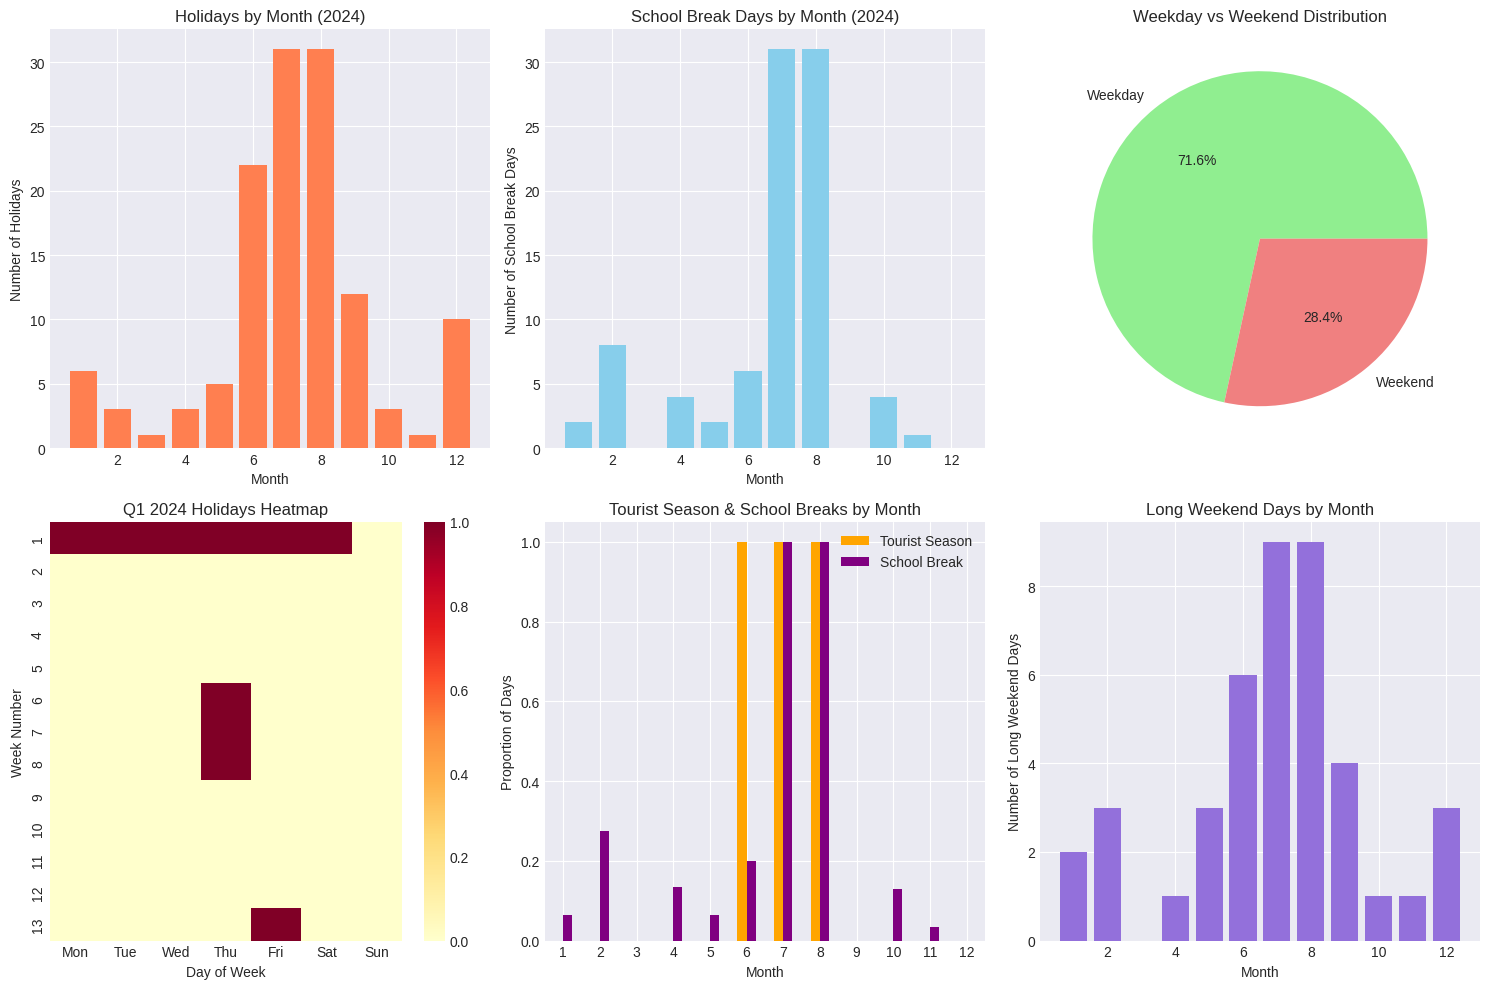

In [5]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Holidays by month
holiday_by_month = calendar_features.groupby('month')['is_holiday'].sum()
axes[0, 0].bar(holiday_by_month.index, holiday_by_month.values, color='coral')
axes[0, 0].set_title('Holidays by Month (2024)')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Holidays')

# 2. School breaks by month
school_break_by_month = calendar_features.groupby('month')['is_school_break'].sum()
axes[0, 1].bar(school_break_by_month.index, school_break_by_month.values, color='skyblue')
axes[0, 1].set_title('School Break Days by Month (2024)')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of School Break Days')

# 3. Weekend distribution
weekend_counts = calendar_features['is_weekend'].value_counts()
axes[0, 2].pie(weekend_counts.values, labels=['Weekday', 'Weekend'], 
               autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axes[0, 2].set_title('Weekday vs Weekend Distribution')

# 4. Special days heatmap for Q1 2024
q1_data = calendar_features[calendar_features['quarter'] == 1].copy()
q1_data['week'] = q1_data['date'].dt.isocalendar().week
q1_pivot = q1_data.pivot_table(
    values='is_holiday', 
    index='week', 
    columns='dayofweek', 
    fill_value=0
)
sns.heatmap(q1_pivot, cmap='YlOrRd', cbar=True, ax=axes[1, 0], 
            xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 0].set_title('Q1 2024 Holidays Heatmap')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Week Number')

# 5. Tourist season overlap
tourist_data = calendar_features.groupby('month')[['is_tourist_season', 'is_school_break']].mean()
tourist_data.plot(kind='bar', ax=axes[1, 1], color=['orange', 'purple'])
axes[1, 1].set_title('Tourist Season & School Breaks by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Proportion of Days')
axes[1, 1].legend(['Tourist Season', 'School Break'])
axes[1, 1].tick_params(axis='x', rotation=0)

# 6. Long weekends
long_weekend_months = calendar_features.groupby('month')['is_long_weekend'].sum()
axes[1, 2].bar(long_weekend_months.index, long_weekend_months.values, color='mediumpurple')
axes[1, 2].set_title('Long Weekend Days by Month')
axes[1, 2].set_xlabel('Month')
axes[1, 2].set_ylabel('Number of Long Weekend Days')

plt.tight_layout()
plt.show()

## 5. Merge with Traffic Data

In [6]:
# Load sample traffic data
try:
    traffic_df = pd.read_csv('../data/production_merged_vehicle_speed.csv', nrows=10000)
    print('Loaded traffic data')
except:
    # Create synthetic traffic data
    np.random.seed(42)
    traffic_df = pd.DataFrame({
        'timestamp': pd.date_range('2024-01-01', periods=10000, freq='H'),
        'sensor_id': np.random.choice(['S001', 'S002', 'S003'], 10000),
        'vehicle_count': np.random.poisson(50, 10000),
        'avg_speed': np.random.normal(80, 15, 10000)
    })
    print('Created synthetic traffic data')

# Ensure timestamp is datetime
if 'timestamp' in traffic_df.columns:
    traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
    traffic_df['date'] = traffic_df['timestamp'].dt.date
    traffic_df['date'] = pd.to_datetime(traffic_df['date'])
else:
    # Find date column
    date_cols = [col for col in traffic_df.columns if 'date' in col.lower() or 'time' in col.lower()]
    if date_cols:
        traffic_df['timestamp'] = pd.to_datetime(traffic_df[date_cols[0]])
        traffic_df['date'] = traffic_df['timestamp'].dt.date
        traffic_df['date'] = pd.to_datetime(traffic_df['date'])

print(f'Traffic data shape before merge: {traffic_df.shape}')

# Generate calendar features for traffic dates
unique_dates = traffic_df['date'].unique()
calendar_features_traffic = generate_calendar_features(unique_dates)

# Merge calendar features with traffic data
traffic_with_calendar = traffic_df.merge(
    calendar_features_traffic,
    on='date',
    how='left'
)

print(f'Traffic data shape after merge: {traffic_with_calendar.shape}')
print('\nNew calendar columns added:')
new_cols = [col for col in traffic_with_calendar.columns if col not in traffic_df.columns]
print(new_cols[:10], '...' if len(new_cols) > 10 else '')

Loaded traffic data
Traffic data shape before merge: (10000, 15)
Traffic data shape after merge: (10000, 33)

New calendar columns added:
['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend', 'is_weekday', 'day_name'] ...


## 6. Analyze Traffic Patterns by Calendar Features

In [7]:
# Analyze impact of calendar features on traffic
if 'vehicle_count' in traffic_with_calendar.columns:
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Traffic on holidays vs non-holidays
    holiday_traffic = traffic_with_calendar.groupby('is_holiday')['vehicle_count'].mean()
    axes[0, 0].bar(['Regular Day', 'Holiday'], holiday_traffic.values, color=['green', 'red'])
    axes[0, 0].set_title('Average Traffic: Holidays vs Regular Days')
    axes[0, 0].set_ylabel('Average Vehicle Count')
    
    # 2. Traffic on weekends vs weekdays
    weekend_traffic = traffic_with_calendar.groupby('is_weekend')['vehicle_count'].mean()
    axes[0, 1].bar(['Weekday', 'Weekend'], weekend_traffic.values, color=['blue', 'orange'])
    axes[0, 1].set_title('Average Traffic: Weekdays vs Weekends')
    axes[0, 1].set_ylabel('Average Vehicle Count')
    
    # 3. Traffic during school breaks
    school_traffic = traffic_with_calendar.groupby('is_school_break')['vehicle_count'].mean()
    axes[1, 0].bar(['School Days', 'School Break'], school_traffic.values, color=['purple', 'yellow'])
    axes[1, 0].set_title('Average Traffic: School Days vs Breaks')
    axes[1, 0].set_ylabel('Average Vehicle Count')
    
    # 4. Traffic by day of week
    dow_traffic = traffic_with_calendar.groupby('dayofweek')['vehicle_count'].mean()
    axes[1, 1].bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
                   dow_traffic.values, color='teal')
    axes[1, 1].set_title('Average Traffic by Day of Week')
    axes[1, 1].set_ylabel('Average Vehicle Count')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print('Traffic Pattern Analysis:')
    print('=' * 50)
    print(f'Holiday vs Regular: {holiday_traffic[1]:.1f} vs {holiday_traffic[0]:.1f} vehicles')
    print(f'Weekend vs Weekday: {weekend_traffic[1]:.1f} vs {weekend_traffic[0]:.1f} vehicles')
    print(f'School Break vs School Days: {school_traffic[1]:.1f} vs {school_traffic[0]:.1f} vehicles')
else:
    print('No vehicle_count column found for analysis')

No vehicle_count column found for analysis


## 7. Save Calendar Features

In [8]:
# Save calendar features for entire period
full_date_range = pd.date_range('2020-01-01', '2024-12-31', freq='D')
full_calendar_features = generate_calendar_features(full_date_range)

# Save to CSV
output_path = '../data/features/calendar_features.csv'
full_calendar_features.to_csv(output_path, index=False)
print(f'Calendar features saved to {output_path}')
print(f'Shape: {full_calendar_features.shape}')

# Display feature statistics
print('\nFeature Statistics:')
print('-' * 50)
binary_features = ['is_weekend', 'is_holiday', 'is_school_break', 
                  'is_tourist_season', 'is_long_weekend']
for feature in binary_features:
    if feature in full_calendar_features.columns:
        pct = full_calendar_features[feature].mean() * 100
        count = full_calendar_features[feature].sum()
        print(f'{feature:20} : {count:4} days ({pct:.1f}%)')

Calendar features saved to ../data/features/calendar_features.csv
Shape: (1827, 19)

Feature Statistics:
--------------------------------------------------
is_weekend           :  522 days (28.6%)
is_holiday           :  635 days (34.8%)
is_school_break      :  477 days (26.1%)
is_tourist_season    :  460 days (25.2%)
is_long_weekend      :  187 days (10.2%)


## 8. Create Helper Functions

In [9]:
def add_calendar_features(df, date_column='timestamp'):
    """
    Add calendar features to any dataframe with a date column
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    date_column : str
        Name of the date/timestamp column
    
    Returns:
    --------
    pd.DataFrame with calendar features added
    """
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    df['date'] = df[date_column].dt.date
    df['date'] = pd.to_datetime(df['date'])
    
    # Generate calendar features
    unique_dates = df['date'].unique()
    calendar_feats = generate_calendar_features(unique_dates)
    
    # Merge
    df = df.merge(calendar_feats, on='date', how='left')
    
    return df

def get_special_days(year=2024, country='SI'):
    """
    Get list of special days (holidays, school breaks) for a given year
    
    Parameters:
    -----------
    year : int
        Year to get special days for
    country : str
        Country code (default: SI for Slovenia)
    
    Returns:
    --------
    dict with holidays and school_breaks
    """
    year_holidays = holidays_df[holidays_df['date'].dt.year == year] if 'date' in holidays_df.columns else pd.DataFrame()
    year_breaks = school_breaks_df[school_breaks_df['year'] == year] if 'year' in school_breaks_df.columns else pd.DataFrame()
    
    holidays_list = []
    if not year_holidays.empty and 'date' in year_holidays.columns:
        cols = ['date', 'name'] if 'name' in year_holidays.columns else ['date']
        holidays_list = year_holidays[cols].to_dict('records')
    
    breaks_list = []
    if not year_breaks.empty:
        cols = [c for c in ['name', 'start', 'end'] if c in year_breaks.columns]
        if cols:
            breaks_list = year_breaks[cols].to_dict('records')
    
    return {
        'holidays': holidays_list,
        'school_breaks': breaks_list
    }

# Test the functions
print('Helper functions created!')
print('\nExample usage:')
print("df_with_calendar = add_calendar_features(df, 'timestamp')")
print("special_days_2024 = get_special_days(2024)")

# Show example
special_2024 = get_special_days(2024)
print(f"\n2024 has {len(special_2024['holidays'])} holidays and {len(special_2024['school_breaks'])} school break periods")

Helper functions created!

Example usage:
df_with_calendar = add_calendar_features(df, 'timestamp')
special_days_2024 = get_special_days(2024)

2024 has 326 holidays and 5 school break periods


## 9. Summary

In [10]:
print('=' * 50)
print('CALENDAR FEATURES COMPLETE')
print('=' * 50)
print('\nAccomplishments:')
print('✓ Loaded/created holiday data for Slovenia')
print('✓ Defined school break periods')
print('✓ Generated comprehensive calendar features')
print('✓ Created binary indicators for special days')
print('✓ Merged calendar features with traffic data')
print('✓ Analyzed traffic patterns by calendar features')
print('✓ Saved calendar features for 2020-2024')
print('\nFeatures Created:')
print('• Basic: year, month, day, dayofweek, quarter')
print('• Binary: is_weekend, is_holiday, is_school_break')
print('• Special: is_tourist_season, is_long_weekend')
print('• Adjacent: day_before_holiday, day_after_holiday')
print('\nFiles Created:')
print('• ../data/features/calendar_features.csv')

CALENDAR FEATURES COMPLETE

Accomplishments:
✓ Loaded/created holiday data for Slovenia
✓ Defined school break periods
✓ Generated comprehensive calendar features
✓ Created binary indicators for special days
✓ Merged calendar features with traffic data
✓ Analyzed traffic patterns by calendar features
✓ Saved calendar features for 2020-2024

Features Created:
• Basic: year, month, day, dayofweek, quarter
• Binary: is_weekend, is_holiday, is_school_break
• Special: is_tourist_season, is_long_weekend
• Adjacent: day_before_holiday, day_after_holiday

Files Created:
• ../data/features/calendar_features.csv
